Import packages and set paths

In [26]:
import os
import sys
import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import numpy as np
import xarray as xr

import warnings

# # Suppress DeprecationWarning
# warnings.filterwarnings("ignore", category=DeprecationWarning)
# warnings.filterwarnings("ignore", message="invalid value encountered in long_scalars")
# warnings.filterwarnings("ignore", message="invalid value encountered in divide")

# Navigate to my EMC2 project data directory
os.chdir('/g/data/jk72/ck4840/projects/emc2/data/')
# Check current project data directory
print("Project data directory:", os.getcwd())
# Create list of merged product files
lidar_radar_merged_list = os.listdir('marcus_merged_lidar_radar')
# Sort the list by date
def extract_date(filepath):
    return filepath[12:-3]
lidar_radar_merged_list = sorted(lidar_radar_merged_list, key = extract_date)
lidar_radar_merged_list

Project data directory: /g/data/jk72/ck4840/projects/emc2/data


['LIDAR-RADAR_merged.20180201.nc',
 'LIDAR-RADAR_merged.20180202.nc',
 'LIDAR-RADAR_merged.20180203.nc',
 'LIDAR-RADAR_merged.20180204.nc',
 'LIDAR-RADAR_merged.20180205.nc',
 'LIDAR-RADAR_merged.20180206.nc',
 'LIDAR-RADAR_merged.20180207.nc']

# UM regional model

In [27]:
# Get the height and time values from the UM regional model to interpolate the lidar-radar data onto
# Focus week dates: 2018-02-01 through 2018-02-07 (inclusive)
um_reg_marcus_20180204 = xr.open_dataset('/g/data/jk72/ck4840/projects/emc2/data/um_reg/um_reg_output/um_reg_marcus_20180204.nc')
um_reg_heights = np.unique(um_reg_marcus_20180204.height_var.values)
um_reg_times = np.unique(um_reg_marcus_20180204.time.values)
# print(um_reg_heights)
# print(um_reg_times)
print('Number of height values:', len(um_reg_heights))
print('Number of time values:', len(um_reg_times))
um_reg_marcus_20180204

Number of height values: 90
Number of time values: 144


<xarray.Dataset>
Dimensions:                                     (level_height: 90, time: 144)
Coordinates:
  * level_height                                (level_height) float64 5.0 .....
  * time                                        (time) datetime64[ns] 2018-02...
Data variables: (12/20)
    cloud_volume_fraction_in_atmosphere_layer   (time, level_height) float64 ...
    mass_fraction_of_cloud_ice_crystals_in_air  (time, level_height) float64 ...
    air_pressure                                (time, level_height) float64 ...
    air_temperature                             (time, level_height) float64 ...
    cloud_area_fraction_in_atmosphere_layer     (time, level_height) float64 ...
    mass_fraction_of_cloud_ice_in_air           (time, level_height) float64 ...
    ...                                          ...
    number_of_cloud_droplets_per_kg_of_air      (time, level_height) float64 ...
    number_of_ice_particles_per_kg_of_air       (time, level_height) float64 ...
    number_of_rain_drops_per_kg_of_air          (time, level_height) float64 ...
    number_of_snow_aggregates_per_kg_of_air     (time, level_height) float64 ...
    number_of_graupel_particles_per_kg_of_air   (time, level_height) float64 ...
    specific_humidity                           (time, level_height) float64 ...
Attributes:
    description:    UM regional model data subsetted to the MARCUS RSV location
    authors:        Calum L. Knight & Sonya L. Fiddes
    creation_date:  2024-04-02

# MARCUS merged-lidar radar product - averaging

In [39]:
# Load the merged lidar-radar product
current_file = lidar_radar_merged_list[3]
lidar_radar_merged = xr.open_dataset(f'marcus_merged_lidar_radar/{current_file}', decode_times = False)
# Set the current date
date_str = current_file.split('_')[-1].split('.')[1][-8:]
# Convert the 'height' variable to metres
lidar_radar_merged['height'] = lidar_radar_merged['height'] * 1000
# Create a total backscatter variable and add it to the dataset
lidar_radar_merged['merged_backscatter'] = np.log10(10**lidar_radar_merged['copol_backscatter'] + 10**lidar_radar_merged['crosspol_backscatter'])

print(date_str)
lidar_radar_merged

20180204


<xarray.Dataset>
Dimensions:               (hour: 1440, height: 1001, status: 3)
Coordinates:
  * hour                  (hour) float32 0.0 0.01667 0.03333 ... 23.97 23.98
  * height                (height) float32 7.495 22.48 ... 1.498e+04 1.5e+04
    status                (hour) float32 ...
Data variables: (12/15)
    Fog_Or_Low_Cloud      (hour) float32 ...
    rcldmask              (height, hour) float32 ...
    lcldmask              (height, hour) float32 ...
    cld_mask              (height, hour) float32 ...
    cld_phase             (height, hour) float32 ...
    copol_backscatter     (height, hour) float32 nan nan nan nan ... nan nan nan
    ...                    ...
    P                     (height, hour) float32 ...
    reflectivity          (height, hour) float32 ...
    doppler               (height, hour) float32 ...
    cld_nlayer            (status, hour) float64 ...
    cld_cover_type        (status, height, hour) float32 ...
    merged_backscatter    (height, hour) float32 nan nan nan nan ... nan nan nan

In [40]:
# Create new xarray dataset to store the averaged variables
lidar_radar_merged_um_reg_resolution = xr.Dataset()

# Select the variables
backscatter = lidar_radar_merged['merged_backscatter']
depolarization_ratio = lidar_radar_merged['depolarization_ratio']
reflectivity = lidar_radar_merged['reflectivity']
# var = var.fillna(0)
# var = xr.where(np.isinf(var), 0, var)

# Floor 'hour' values to the nearest 10
backscatter['hour_floor'] = np.floor(60 * backscatter['hour'] / 10) * 10
depolarization_ratio['hour_floor'] = np.floor(60 * depolarization_ratio['hour'] / 10) * 10
reflectivity['hour_floor'] = np.floor(60 * reflectivity['hour'] / 10) * 10

# # Group by 'hour_floor' dimension and take the mean along 'height' dimension
averaged_backscatter = backscatter.groupby(backscatter['hour_floor']).mean(dim='hour')
averaged_depolarization_ratio = depolarization_ratio.groupby(depolarization_ratio['hour_floor']).mean(dim='hour')
averaged_reflectivity = reflectivity.groupby(reflectivity['hour_floor']).mean(dim='hour')

# Interpolate data from 'height' coordinate onto 'um_reg_heights' coordinate
averaged_backscatter = averaged_backscatter.interp(height=um_reg_heights)
averaged_depolarization_ratio = averaged_depolarization_ratio.interp(height=um_reg_heights)
averaged_reflectivity = averaged_reflectivity.interp(height=um_reg_heights)

# Assign the averaged variables to the new dataset
lidar_radar_merged_um_reg_resolution['merged_backscatter'] = averaged_backscatter
lidar_radar_merged_um_reg_resolution['depolarization_ratio'] = averaged_depolarization_ratio
lidar_radar_merged_um_reg_resolution['reflectivity'] = averaged_reflectivity

# Rename coordinates, repair time coordinate
lidar_radar_merged_um_reg_resolution = lidar_radar_merged_um_reg_resolution.rename({'height': 'um_reg_heights', 'hour_floor': 'um_reg_times'})
lidar_radar_merged_um_reg_resolution['um_reg_times'] = um_reg_times

lidar_radar_merged_um_reg_resolution

<xarray.Dataset>
Dimensions:               (um_reg_times: 144, um_reg_heights: 90)
Coordinates:
  * um_reg_times          (um_reg_times) datetime64[ns] 2018-02-04T00:01:15 ....
  * um_reg_heights        (um_reg_heights) float64 5.0 17.14 ... 3.867e+04 4e+04
Data variables:
    merged_backscatter    (um_reg_heights, um_reg_times) float64 nan nan ... nan
    depolarization_ratio  (um_reg_heights, um_reg_times) float64 nan nan ... nan
    reflectivity          (um_reg_heights, um_reg_times) float64 nan nan ... nan

In [44]:
# Create the modified version of lidar_radar_merged for regridding cloud phase
lidar_radar_merged_mod = lidar_radar_merged.copy()

# Convert lidar_radar_merged 'hour' coordinate to an actual datetime called 'time'
# Convert date_str to datetime object
date_obj = datetime.datetime.strptime(date_str, '%Y%m%d')
# Convert hour coordinate to datetime
minutes_since_start_of_day = np.round(lidar_radar_merged_mod['hour'] * 60)  # Convert hours to minutes
# Create a timedelta array using minutes_since_start_of_day
timedelta_array = np.array([datetime.timedelta(minutes=int(minutes)) for minutes in minutes_since_start_of_day])
# Convert timedelta array to datetime array by adding to the current date
datetime_array = date_obj + timedelta_array
# Assign values of datetime_array to the 'hour' coordinate in test
lidar_radar_merged_mod['hour'] = datetime_array
# Rename the 'hour' coordinate to 'time'
lidar_radar_merged_mod = lidar_radar_merged_mod.rename({'hour': 'time'})

# Create a coordinate dictionary
coords = {'um_reg_times': um_reg_times, 'um_reg_heights': um_reg_heights}
# Create a numpy array filled with NaNs for the cld_phase variable
cld_phase_data = np.full((len(um_reg_times), len(um_reg_heights)), np.nan)
# Create the xarray dataset
regridded_lidar_radar = xr.Dataset({'cld_phase': (['um_reg_times', 'um_reg_heights'], cld_phase_data)},coords=coords)

variables_to_keep = ['time', 'height', 'cld_phase']
lidar_radar_merged_mod = lidar_radar_merged_mod.drop_vars([var for var in lidar_radar_merged_mod.variables if var not in variables_to_keep])
# Hydrometeor classification: 0=Clear; 1=Liquid Warm; 2=Ice Virga; 3=Supercooled Liquid; 4=mixed phase; 5=Ice or Mixed phase; 6=Ice; 7=Liquid Virga; 8=Aerosol
lidar_radar_merged_mod['cld_phase'] = xr.where(lidar_radar_merged_mod['cld_phase'] == 8, 0, lidar_radar_merged_mod['cld_phase']) # Aerosol to clear sky
lidar_radar_merged_mod['cld_phase'] = xr.where(lidar_radar_merged_mod['cld_phase'] == 3, 1, lidar_radar_merged_mod['cld_phase']) # SLW to liquid
lidar_radar_merged_mod['cld_phase'] = xr.where(lidar_radar_merged_mod['cld_phase'] == 7, 1, lidar_radar_merged_mod['cld_phase']) # Liquid virga to Liquid
lidar_radar_merged_mod['cld_phase'] = xr.where(lidar_radar_merged_mod['cld_phase'] == 5, 2, lidar_radar_merged_mod['cld_phase']) # Ice to Ice
lidar_radar_merged_mod['cld_phase'] = xr.where(lidar_radar_merged_mod['cld_phase'] == 6, 2, lidar_radar_merged_mod['cld_phase']) # Ice or Mixed phase to Ice
lidar_radar_merged_mod['cld_phase'] = xr.where(lidar_radar_merged_mod['cld_phase'] == 4, 3, lidar_radar_merged_mod['cld_phase']) # Mixed phase to Mixed
# Consolidated classification: 0=Clear, 1=Liquid, 2=Ice, 3=Mixed

for i in np.arange(len(um_reg_times) - 1): # length of time dimension
    for j in np.arange(len(um_reg_heights) - 1): # length of height dimension
    
        # i, j = 45, 40
        # i, j = 43, 40
        # i, j = 43, 60
        
        # Create the current slice of lidar-radar data
        lidar_radar_merged_slice = lidar_radar_merged_mod.sel(height = slice(um_reg_heights[j], um_reg_heights[j + 1]), time = slice(um_reg_times[i], um_reg_times[i + 1]))
        
        # Remove nans
        cld_phase_values = lidar_radar_merged_slice['cld_phase'].values
        cld_phase_values = cld_phase_values[~np.isnan(cld_phase_values)]
        
        # Check if cld_phase_values is empty
        if len(cld_phase_values) == 0:
            regridded_lidar_radar['cld_phase'].values[i, j] = np.nan
            continue # Skip to the next iteration
        
        # Check if more than 50% is clear sky
        if np.count_nonzero(cld_phase_values == 0)/len(cld_phase_values) > 0.5:
            regridded_lidar_radar['cld_phase'].values[i, j] = 0
            continue # Skip to the next iteration
        
        # Remove clear sky
        cld_phase_values = cld_phase_values[cld_phase_values != 0]
        
        # Calculate occurrence frequency of each integer k in cld_phase
        unique_elements, counts = np.unique(cld_phase_values, return_counts = True)
        freq = counts / len(cld_phase_values)
        
        # Assign values to regridded_lidar_radar based on the rules
        for k in range(len(unique_elements)):
            if freq[k] > 0.9:
                regridded_lidar_radar['cld_phase'].values[i, j] = unique_elements[k]
            elif 0.1 < freq[k] < 0.9:
                regridded_lidar_radar['cld_phase'].values[i, j] = 3
            elif freq[k] < 0.1 and (unique_elements[k] == 2 or (unique_elements[k] == 3 and freq[np.where(unique_elements == 3)] > 0.5)):
                regridded_lidar_radar['cld_phase'].values[i, j] = 3
            else:
                regridded_lidar_radar['cld_phase'].values[i, j] = 1

lidar_radar_merged_um_reg_resolution['cld_phase'] = regridded_lidar_radar['cld_phase']
lidar_radar_merged_um_reg_resolution

<xarray.Dataset>
Dimensions:               (um_reg_times: 144, um_reg_heights: 90)
Coordinates:
  * um_reg_times          (um_reg_times) datetime64[ns] 2018-02-04T00:01:15 ....
  * um_reg_heights        (um_reg_heights) float64 5.0 17.14 ... 3.867e+04 4e+04
Data variables:
    merged_backscatter    (um_reg_heights, um_reg_times) float64 nan nan ... nan
    depolarization_ratio  (um_reg_heights, um_reg_times) float64 nan nan ... nan
    reflectivity          (um_reg_heights, um_reg_times) float64 nan nan ... nan
    cld_phase             (um_reg_times, um_reg_heights) float64 nan nan ... nan

# Plotting

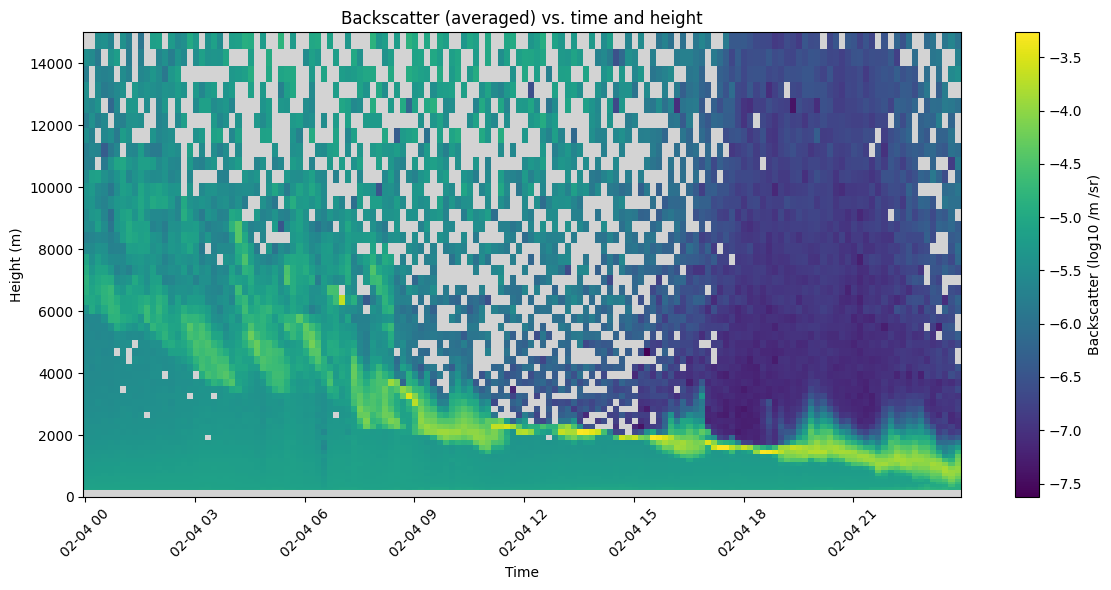

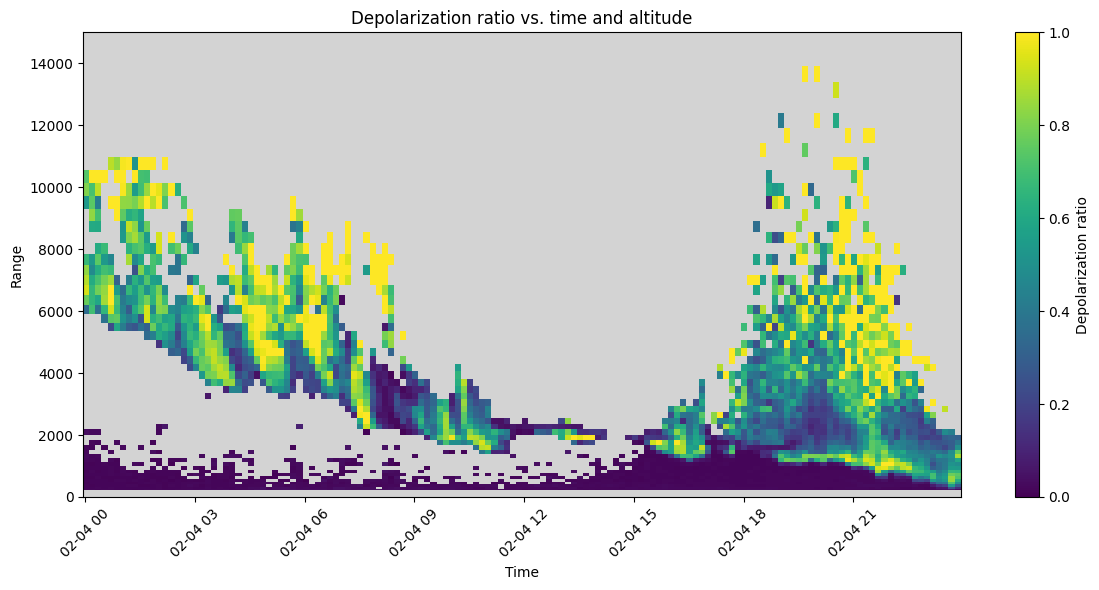

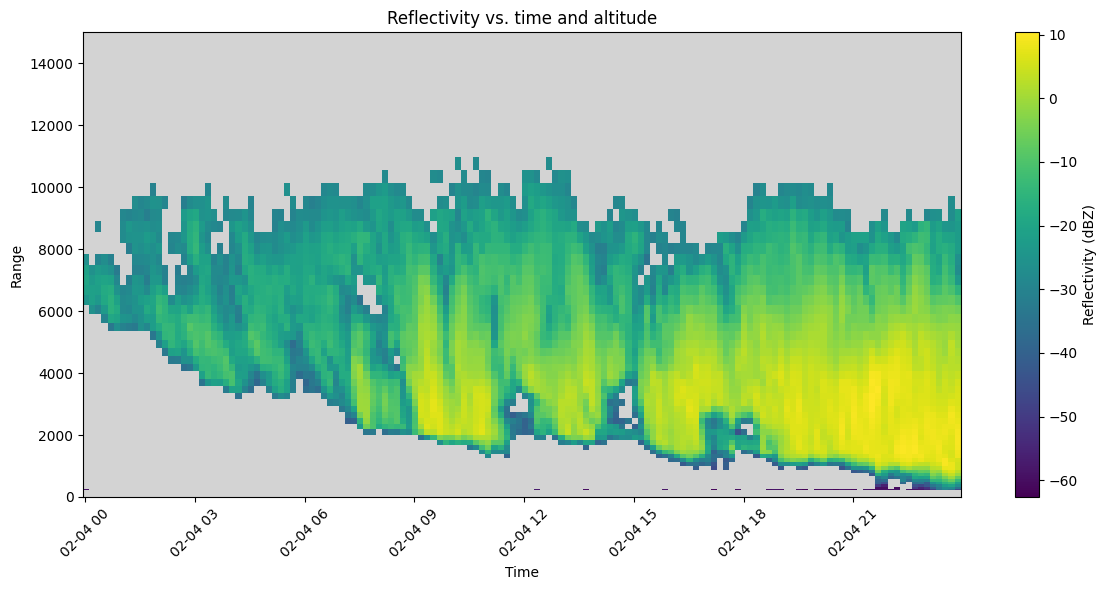

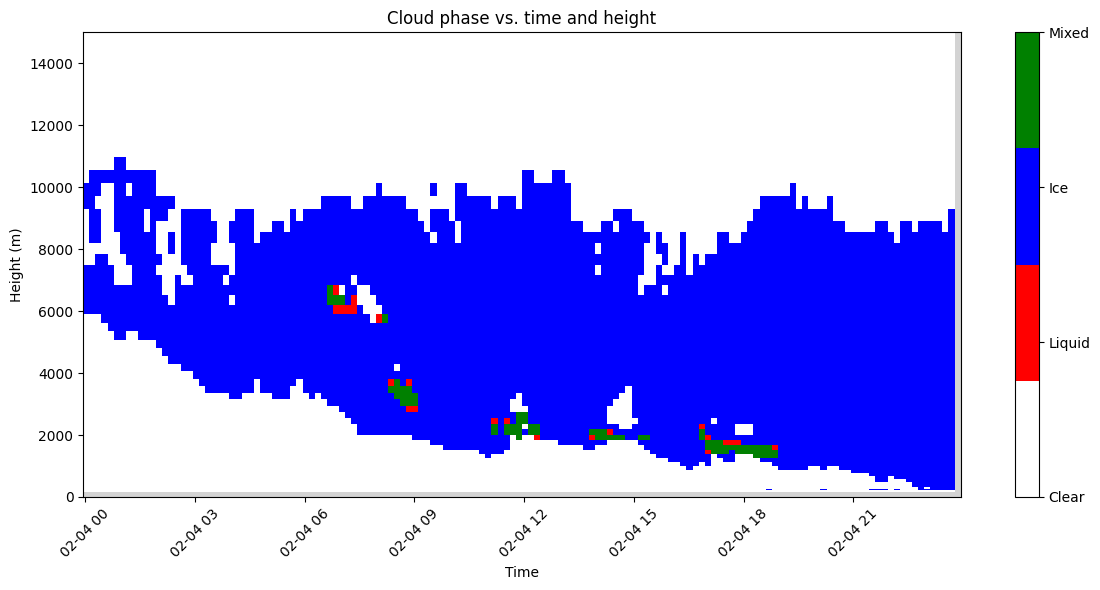

In [46]:
# Set the height limit for the plots
ylim_max = 15000

# Create a meshgrid for time and height to be used for all plots produced from the current file
time_mesh, height_mesh = np.meshgrid(lidar_radar_merged_um_reg_resolution['um_reg_times'], lidar_radar_merged_um_reg_resolution['um_reg_heights'])

# Backscatter
# Extract the desired variable
merged_backscatter = lidar_radar_merged_um_reg_resolution['merged_backscatter']
# Create the plot with a grey background
plt.figure(figsize = (12, 6))
plt.gca().set_facecolor('lightgrey')
# Create and organise a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, merged_backscatter, cmap = 'viridis', shading = 'auto')
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.colorbar(pcm, label = 'Backscatter (log10 /m /sr)')
plt.title('Backscatter (averaged) vs. time and height')
plt.ylim(0,ylim_max)
plt.xticks(rotation = 45)
plt.tight_layout()
# Save and show the plot
averaged_backscatter = plt.gcf()
averaged_backscatter.savefig(f'/g/data/jk72/ck4840/projects/emc2/figs/marcus/merged_lidar_radar/um_reg_resolution/marcus_averaged_backscatter_{date_str}.png', dpi=200)
plt.show()

# Depolarization ratio
# Extract the desired variable
depolarization_ratio = lidar_radar_merged_um_reg_resolution['depolarization_ratio']
# Create the depolarization ratio plot
plt.figure(figsize=(12, 6))
# Set the entire plot background color to grey
plt.gca().set_facecolor('lightgrey')
# Create a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, depolarization_ratio, cmap='viridis', vmin = 0, vmax = 1)
# Set plot labels, limits, and layout
plt.colorbar(pcm, label = 'Depolarization ratio')
plt.xlabel('Time')
plt.ylabel('Range')
plt.ylim(0,ylim_max)
plt.title('Depolarization ratio vs. time and altitude')
plt.xticks(rotation=45)
plt.tight_layout()
# Save and show the plot
averaged_depolarization_ratio = plt.gcf()
averaged_depolarization_ratio.savefig(f'/g/data/jk72/ck4840/projects/emc2/figs/marcus/merged_lidar_radar/um_reg_resolution/marcus_averaged_depolarization_ratio_{date_str}.png', dpi=200)
plt.show()

# Reflectivity
# Extract the desired variable
reflectivity = lidar_radar_merged_um_reg_resolution['reflectivity']
# Create the reflectivity plot
plt.figure(figsize=(12, 6))
# Set the entire plot background color to grey
plt.gca().set_facecolor('lightgrey')
# Create a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, reflectivity, cmap='viridis')
# Set plot labels, limits, and layout
plt.colorbar(pcm, label='Reflectivity (dBZ)')
plt.xlabel('Time')
plt.ylabel('Range')
plt.ylim(0,ylim_max)
plt.title('Reflectivity vs. time and altitude')
plt.xticks(rotation=45)
plt.tight_layout()
# Save and show the plot
averaged_reflectivity = plt.gcf()
averaged_reflectivity.savefig(f'/g/data/jk72/ck4840/projects/emc2/figs/marcus/merged_lidar_radar/um_reg_resolution/marcus_averaged_reflectivity_{date_str}.png', dpi=200)
plt.show()

# Consolidated cloud phase
# Extract the desired variables
merged_cloud_phase = lidar_radar_merged_um_reg_resolution['cld_phase']
# Create the cloud phase plot
plt.figure(figsize=(12, 6))
# Define custom colors for each phase
colors_mod = ['white', 'red', 'blue', 'green']
# Define corresponding phase labels
phase_labels_mod = ['Clear', 'Liquid', 'Ice', 'Mixed']
# Create a ListedColormap with custom colors
cmap_mod = ListedColormap(colors_mod)
# Set the entire plot background color to grey
plt.gca().set_facecolor('lightgrey')
# Create a pcolormesh plot
pcm = plt.pcolormesh(time_mesh, height_mesh, merged_cloud_phase.T, cmap = cmap_mod)
# Set colorbar ticks and labels
cbar = plt.colorbar(pcm, ticks = range(4))
cbar.ax.set_yticklabels(phase_labels_mod)
# Set plot labels, limits, and layout
# plt.colorbar(pcm, label='Cloud phase')
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.ylim(0,ylim_max)
plt.title('Cloud phase vs. time and height')
plt.xticks(rotation=45)
plt.tight_layout()
# Save and show the plot
averaged_cloud_phase = plt.gcf()
averaged_cloud_phase.savefig(f'/g/data/jk72/ck4840/projects/emc2/figs/marcus/merged_lidar_radar/um_reg_resolution/marcus_averaged_cloud_phase_{date_str}.png', dpi=200)
plt.show()